## Прогнозирование роста человека по весу

### Импортируем нужные библиотеки

In [483]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

### Загрузим датасет

In [484]:
data = pd.read_csv('weights_heights.csv', index_col='Index')

In [485]:
data.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


### Построим гистограмму распределения роста и веса

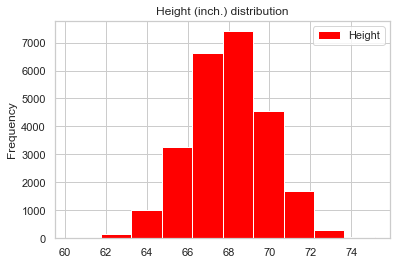

In [486]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution')

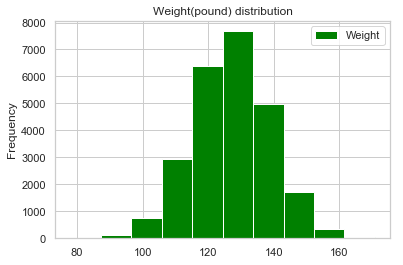

In [487]:
data.plot(y='Weight', kind='hist', color='green', title='Weight(pound) distribution')

### Добавим признак индекса массы тела (BMI)

In [488]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [489]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

In [490]:
data.head()

,Height,Weight,BMI
Index,,,
1,65.78331,112.9925,18.357573
2,71.51521,136.4873,18.762577
3,69.39874,153.0269,22.338895
4,68.21660,142.3354,21.504526
5,67.78781,144.2971,22.077581


### Построим попарную зависимость признаков

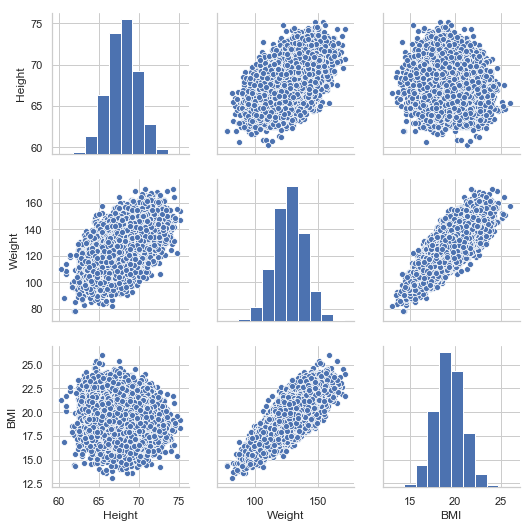

In [491]:
sns.pairplot(data)

### Посмотрим на распределение весовых категорий

Text(0.5,0,'Weight category')

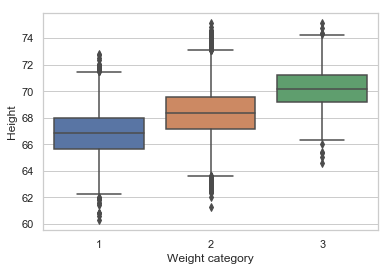

In [492]:
def weight_category(weight):
    if(weight<120):
        return 1
    elif(weight>=150):
        return 3
    else:
        return 2

data['weight_cat'] = data['Weight'].apply(weight_category)

sns.set(style="whitegrid")
g=sns.boxplot(x=data['weight_cat'],y=data['Height'])
plt.xlabel('Weight category')

### Scatter plot зависимости роста от веса

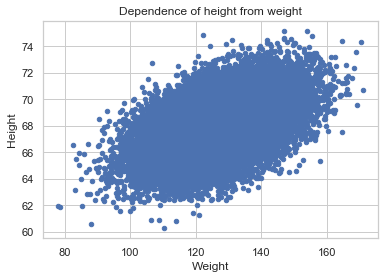

In [493]:
data.plot(y="Height",x="Weight",kind='scatter',title='Dependence of height from weight')

## Разобьем выборку на обучающую и тестовую:

### Решим эту задачу с помощью библиотеки Skitit-learn

In [494]:
from sklearn import model_selection

In [495]:
train, test = model_selection.train_test_split(data, test_size = 0.2)

##### Убедимся, что разбиение произошло в нужном соотношении:

In [496]:
print float(len(test))/(len(train)+len(test))

0.2


# Решим задачу прогнозирования методом линейной регрессии:

## Будем минимизировать функцию среднекватратичной ошибки: $$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$

In [497]:
def error(w0,w1,df):
    s=0
    for i in xrange(len(df)):
        s=s+(df['Height'].iloc[i]-(w0+w1*df['Weight'].iloc[i]))**2
    return s

### Посмотрим, как выглядит функция среднеквадратичной ошибки для обучающей выборки:

In [498]:
from mpl_toolkits.mplot3d import Axes3D

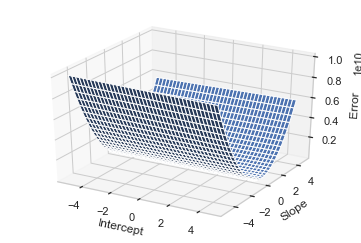

In [499]:
err_fig=plt.figure()
ax_err=err_fig.gca(projection='3d')
eX=np.arange(-5,5,0.25)
eY=np.arange(-5,5,0.25)
eX,eY=np.meshgrid(eX,eY)
eZ=error(eX,eY,train)

surf_err=ax_err.plot_surface(eX,eY,eZ)
ax_err.set_xlabel('Intercept')
ax_err.set_ylabel('Slope')
ax_err.set_zlabel('Error')
plt.show()

## Минимизурем функционал ошибки:

### Методами scipy отыщем минимум функции

#### воспользуемся методом L-BFGS-B, будем искать минимум на промежутке (-100,100);(-5,5) ,с начальным шагом в точке (0;0)

In [500]:
%%time
from scipy.optimize import minimize,rosen
x0=np.array([0.0,0.0])
res1=minimize(lambda x:error(x[0],x[1],train),x0,method='L-BFGS-B',bounds=[(-100,100),(-5,5)])
print res1.x

[57.58875565  0.08188959]
Wall time: 39.9 s


### нарисуем прямую, соответствующую найденным параметрам, на scatter plot всей выборки:

Text(0.5,1,'Prediction of Height by Weight')

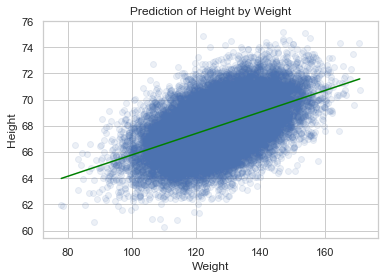

In [501]:
x=np.linspace(data['Weight'].min(),data['Weight'].max(),100)
def y(w0,w1):
    return w0+w1*x
plt.plot(x,y(res.x[0],res.x[1]), c='green')
plt.scatter(data['Weight'],data['Height'],alpha=0.1)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Prediction of Height by Weight')

In [502]:
%%time
from scipy.optimize import minimize,rosen
x0=np.array([0.0,0.0])
res2=minimize(lambda x:error(x[0],x[1],test),x0,method='L-BFGS-B',bounds=[(-100,100),(-5,5)])
print res2.x

[57.50330584  0.08247848]
Wall time: 9.22 s


In [503]:
error(res2.x[0],res2.x[1],test)/error(res1.x[0],res1.x[1],test)

0.9999398750993703